# Libraries to be used

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "drive/MyDrive/4650 Project"

/content/drive/MyDrive/4650 Project


# Clean tweets here so that it is basically raw text

In [4]:
# function for cleaning tweets
def clean_text(text):
    if not isinstance(text, str):
        return ""  # empty string for any non-string input
    text = re.sub(r"http\S+", "", text) # remove URLs
    text = re.sub(r"@\S+", "", text) # remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text) # remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip() # change multiple spaces to single space
    return text.lower() # convert to lowercase

# load tagged world cup tweets
fifa_tweets = pd.read_csv('fifa_world_cup_2022_tweets.csv')

# clean world cup tweets
fifa_tweets['Clean Text'] = fifa_tweets['Tweet'].apply(clean_text)

In [5]:
# establish new cleaned tweets combined with pre-annotated sentiment
combined_tweets = pd.concat([
    fifa_tweets[['Clean Text', 'Sentiment']].rename(columns={'Clean Text': 'Clean Tweet'})
])

combined_tweets.head(), combined_tweets.shape

(                                         Clean Tweet Sentiment
 0                what are we drinking today worldcup   neutral
 1  amazing worldcup launch video shows how much t...  positive
 2              worth reading while watching worldcup  positive
 3  golden maknae shinning bright jeonjungkook jun...  positive
 4  if the bbc cares so much about human rights ho...  negative,
 (22524, 2))

# Load in form of BERT model that we use for training the model

In [6]:
# DistilBert tokenizer converts input text into tokens that are the correct input format for the model.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# DistilBertForSequenceClassification is a pre-trained DistilBERT model for sequence classification tasks.
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Some more preprocessing on data to make it ready for model

In [ ]:
# convert raw text data into a format that is usable for the model
encoded_data = tokenizer.batch_encode_plus(
    combined_tweets['Clean Tweet'].tolist(), # text to be tokenized
    add_special_tokens=True, # adds special tokens (like [CLS] and [SEP]) to each sequence
    return_attention_mask=True, # creates mask for the attention mechanism to ignore padding
    padding='max_length', # pads sequences to the same length
    truncation=True, # truncates sequences that are too long
    max_length=256, # maximum length of the sequences
    return_tensors='pt' # returns PyTorch tensors
)

# the IDs are the token indices in the tokenizer vocabulary
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# converts sentiment labels from strings to integers for model processing
labels = torch.tensor(combined_tweets['Sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': 2}).tolist())

# sanity check for tensor sizes
print(input_ids.shape)
print(attention_masks.shape)
print(labels.shape)

# Create a tensor dataset
dataset = TensorDataset(input_ids, attention_masks, labels)

torch.Size([2252, 256])
torch.Size([2252, 256])
torch.Size([2252])


# Establish training parameters for model

In [ ]:
# set 80% of data for training
train_size = int(0.8 * len(dataset))
# validation set
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# use RandomSampler which samples the data randomly for each epoch to not overfit
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)

# samples the data sequentially during validation runs
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)

# Model Training

In [ ]:
# model and device set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

# function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        # Forward pass to calculate predictions and loss
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # validation step after each epoch
    model.eval()
    eval_accuracy, eval_steps = 0, 0
    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        eval_accuracy += flat_accuracy(logits, label_ids)
        eval_steps += 1

    print('Epoch {}/{} | Loss: {:.3f} | Validation Accuracy: {:.3f}'.format(
        epoch+1, epochs, total_loss/len(train_dataloader), eval_accuracy/eval_steps))

Epoch 1/4 | Loss: 0.276 | Validation Accuracy: 0.942
Epoch 2/4 | Loss: 0.125 | Validation Accuracy: 0.948
Epoch 3/4 | Loss: 0.077 | Validation Accuracy: 0.953
Epoch 4/4 | Loss: 0.047 | Validation Accuracy: 0.953


In [ ]:
# Save the model
model.save_pretrained('./saved_model')

# Save the tokenizer
tokenizer.save_pretrained('./saved_model')

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [5]:
# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('./saved_model')

# Load the model
model = DistilBertForSequenceClassification.from_pretrained('./saved_model')

# Compare out model against VADER and TextBlob Indian Premier League Cricket Tweets

In [11]:
# Load the dataset
df = pd.read_csv('tagged_IPL_2022_tweets.csv')

texts = df['text']
true_labels = df['sentiment']

In [12]:
cleaned_ipl = texts.apply(clean_text)

In [13]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
# VADER
def vader_sentiment(text):
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'POSITIVE'
    elif score['compound'] <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

vader_predictions = cleaned_ipl.apply(vader_sentiment)

# TextBlob
def textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.1:
        return 'POSITIVE'
    elif analysis.sentiment.polarity < -0.1:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

textblob_predictions = cleaned_ipl.apply(textblob_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
device = torch.device("cpu")
model.to(device)
encoded_data = tokenizer.batch_encode_plus(
    cleaned_ipl.tolist(), add_special_tokens=True, return_attention_mask=True,
    padding='max_length', truncation=True, max_length=256, return_tensors='pt'
)
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

# predictions
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)
    model_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

# convert model predictions from numeric to labels
label_mapping = {0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}
model_predictions = [label_mapping[label] for label in model_predictions]


In [15]:
print("Accuracy of our model: ", accuracy_score(true_labels, model_predictions))
print("Accuracy of VADER model: ", accuracy_score(true_labels, vader_predictions))
print("Accuracy of TextBlob model: ", accuracy_score(true_labels, textblob_predictions))

Accuracy of our model:  0.5533333333333333
Accuracy of VADER model:  0.5436666666666666
Accuracy of TextBlob model:  0.48033333333333333


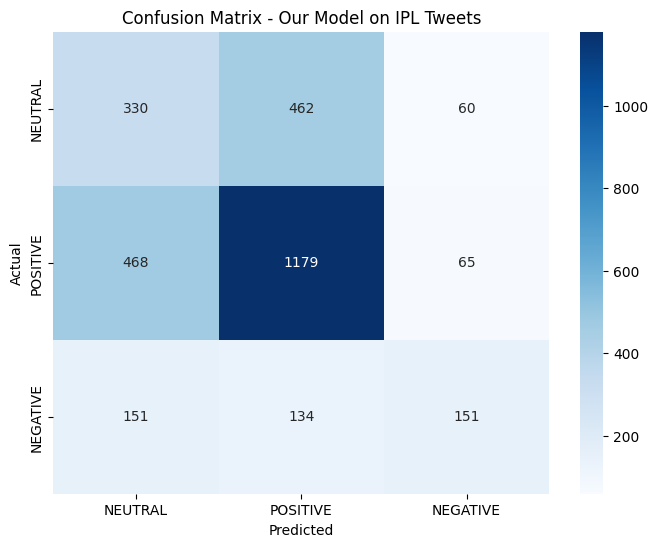

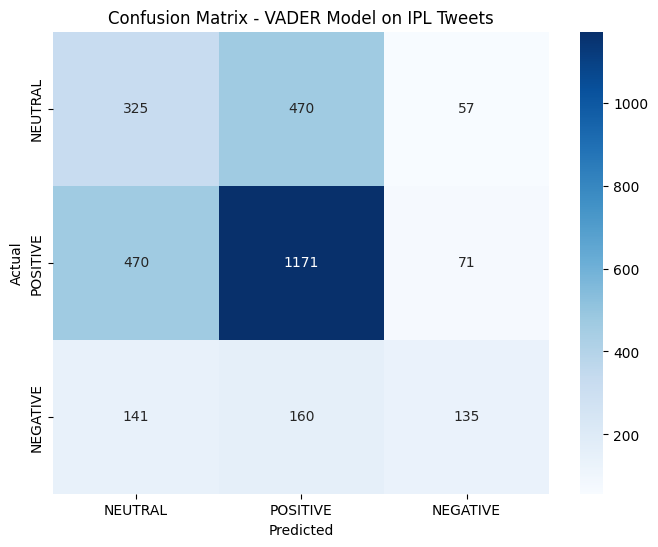

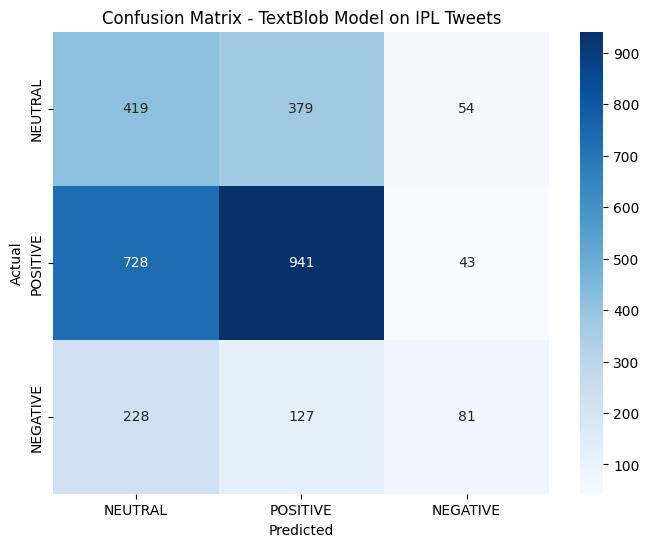

In [16]:
label_categories = ['NEUTRAL', 'POSITIVE', 'NEGATIVE']

# confusion Matrix for Your Model
cm_model = confusion_matrix(true_labels, model_predictions, labels=label_categories)
# confusion Matrix for VADER
cm_vader = confusion_matrix(true_labels, vader_predictions, labels=label_categories)
# confusion Matrix for TextBlob
cm_textblob = confusion_matrix(true_labels, textblob_predictions, labels=label_categories)
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_categories, yticklabels=label_categories)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# plotting matrices
plot_confusion_matrix(cm_model, title='Confusion Matrix - Our Model on IPL Tweets')
plot_confusion_matrix(cm_vader, title='Confusion Matrix - VADER Model on IPL Tweets')
plot_confusion_matrix(cm_textblob, title='Confusion Matrix - TextBlob Model on IPL Tweets')

# The same for Tokyo Olympics tweets

In [12]:
# Load the dataset
df = pd.read_csv('tagged_tokyo_2020_tweets.csv')

texts = df['text']
true_labels = df['sentiment']

In [13]:
cleaned_tokyo = texts.apply(clean_text)

In [14]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sia.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'POSITIVE'
    elif score['compound'] <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

vader_predictions = cleaned_tokyo.apply(vader_sentiment)

# TextBlob
def textblob_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.1:
        return 'POSITIVE'
    elif analysis.sentiment.polarity < -0.1:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

textblob_predictions = cleaned_tokyo.apply(textblob_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# Prepare data for your model
device = torch.device("cpu")
model.to(device)
encoded_data = tokenizer.batch_encode_plus(
    cleaned_tokyo.tolist(), add_special_tokens=True, return_attention_mask=True,
    padding='max_length', truncation=True, max_length=256, return_tensors='pt'
)
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

# Generate predictions
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)
    model_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

# Convert model predictions from numeric to labels
label_mapping = {0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}
model_predictions = [label_mapping[label] for label in model_predictions]


In [16]:
print("Accuracy of our model on Tokyo Olympics Tweets: ", accuracy_score(true_labels, model_predictions))
print("Accuracy of VADER model on Tokyo Olympics Tweets: ", accuracy_score(true_labels, vader_predictions))
print("Accuracy of TextBlob model on Tokyo Olympics Tweets: ", accuracy_score(true_labels, textblob_predictions))

Accuracy of our model on Tokyo Olympics Tweets:  0.622
Accuracy of VADER model on Tokyo Olympics Tweets:  0.611
Accuracy of TextBlob model on Tokyo Olympics Tweets:  0.519


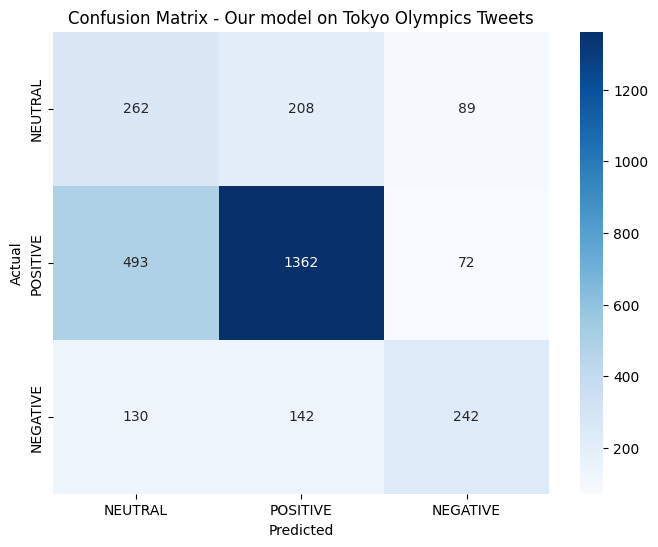

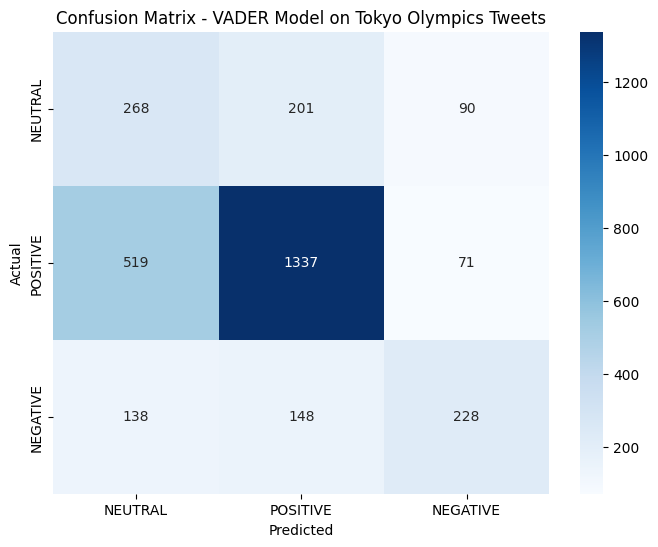

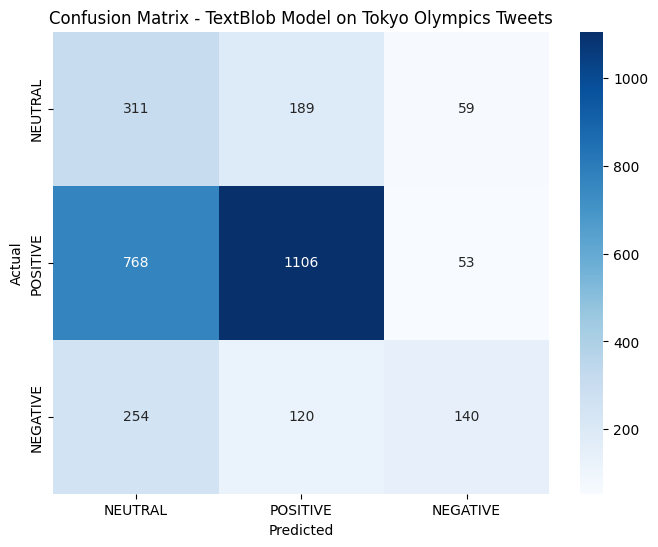

In [17]:
# True labels and predicted labels should be aligned in categories.
label_categories = ['NEUTRAL', 'POSITIVE', 'NEGATIVE']

# Confusion Matrix for Your Model
cm_model = confusion_matrix(true_labels, model_predictions, labels=label_categories)
# Confusion Matrix for VADER
cm_vader = confusion_matrix(true_labels, vader_predictions, labels=label_categories)
# Confusion Matrix for TextBlob
cm_textblob = confusion_matrix(true_labels, textblob_predictions, labels=label_categories)
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_categories, yticklabels=label_categories)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Plotting
plot_confusion_matrix(cm_model, title='Confusion Matrix - Our model on Tokyo Olympics Tweets')
plot_confusion_matrix(cm_vader, title='Confusion Matrix - VADER Model on Tokyo Olympics Tweets')
plot_confusion_matrix(cm_textblob, title='Confusion Matrix - TextBlob Model on Tokyo Olympics Tweets')